In [1]:
import matplotlib.pyplot as plt


In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
from pathlib import Path
import sys
sys.path.append(str(Path.cwd() / "_scripts"))

In [248]:
import networkx as nx
from eppy.bunch_subclass import EpBunch
from geomeppy import IDF
import seaborn as sns
import polars as pl
import numpy as np

from case_edits.ezcase import *
from helpers.helpers import *
from helpers.variables import *
from helpers.variable_interfaces import *
from setup.setup import *
from setup.plots import *
from setup.data_wrangle import *
from network.data_on_network import *

import matplotlib.cm as cm
import matplotlib as mpl


from matplotlib.colors import Colormap, Normalize, LinearSegmentedColormap
from setup.setup import create_directories

from helpers.ep_helpers import *
from subsurfaces.creator import SubsurfaceCreator
from airflow_network.airboundary import *
from subsurfaces.logic import find_surface_connecting_two_zones
from setup.analysis import create_data, get_airboundary_case, get_df, get_zone_df, get_airboundary_with_surf_case, get_qois


In [184]:
# create_cases(AIRBOUNDARY_FOLDER)



qois = get_qois()
cases = retrieve_cases(AIRBOUNDARY_FOLDER)
sc = cases[0]
sc

CaseData(case_name='amb_b1', idf=<geomeppy.idf.IDF object at 0x16bfc7280>, sql=Energy SQLiteResult: /Users/julietnwagwuume-ezeoke/_UILCode/gqe-phd/geomeppy/cases/airboundary/case_amb_b1/results/eplusout.sql, path_to_input=PosixPath('/Users/julietnwagwuume-ezeoke/_UILCode/gqe-phd/svg2plan/outputs2/case_amb_b1'), path_to_output=PosixPath('/Users/julietnwagwuume-ezeoke/_UILCode/gqe-phd/geomeppy/cases/airboundary/case_amb_b1'))

amb_b1


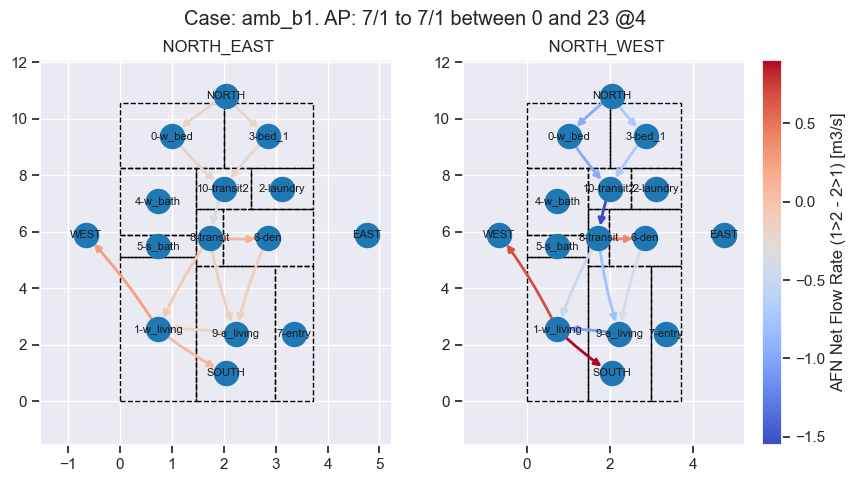

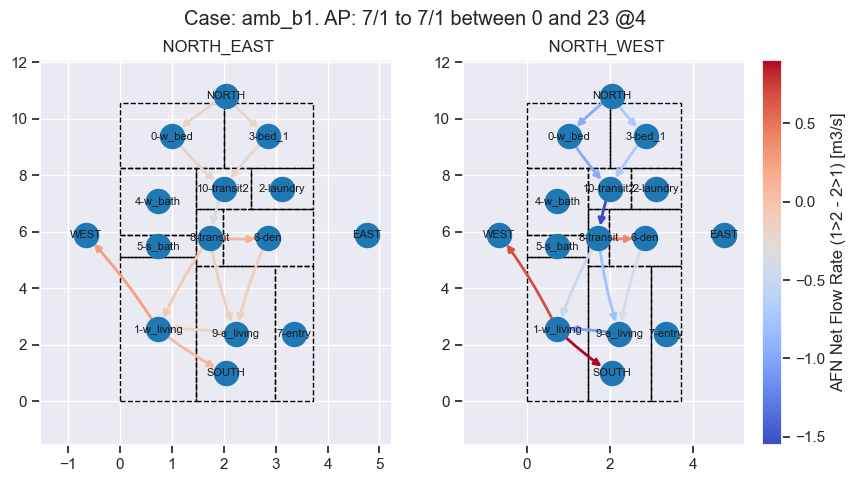

In [275]:
create_data_on_network_fig_facet_winddir(cases, sc)

In [185]:
df = create_dataframe_for_case(sc.case_name, sc.sql, qois[0])
df

case_names,space_names,qoi,values,datetimes
str,str,str,f64,datetime[μs]
"""amb_b1""","""BLOCK 010 STOREY 0 WALL 0002_2…","""AFN Linkage Node 1 to Node 2 V…",0.061249,2017-07-01 00:00:00
"""amb_b1""","""BLOCK 010 STOREY 0 WALL 0002_2…","""AFN Linkage Node 1 to Node 2 V…",0.091203,2017-07-01 00:15:00
"""amb_b1""","""BLOCK 010 STOREY 0 WALL 0002_2…","""AFN Linkage Node 1 to Node 2 V…",0.111956,2017-07-01 00:30:00
"""amb_b1""","""BLOCK 010 STOREY 0 WALL 0002_2…","""AFN Linkage Node 1 to Node 2 V…",0.13722,2017-07-01 00:45:00
"""amb_b1""","""BLOCK 010 STOREY 0 WALL 0002_2…","""AFN Linkage Node 1 to Node 2 V…",0.128805,2017-07-01 01:00:00
…,…,…,…,…
"""amb_b1""","""BLOCK 08 STOREY 0 WALL 0002_1""","""AFN Linkage Node 1 to Node 2 V…",0.0,2017-07-01 22:45:00
"""amb_b1""","""BLOCK 08 STOREY 0 WALL 0002_1""","""AFN Linkage Node 1 to Node 2 V…",0.000002,2017-07-01 23:00:00
"""amb_b1""","""BLOCK 08 STOREY 0 WALL 0002_1""","""AFN Linkage Node 1 to Node 2 V…",0.000728,2017-07-01 23:15:00


In [199]:
afn_surfaces = [i.Surface_Name for i in sc.idf.idfobjects["AIRFLOWNETWORK:MULTIZONE:SURFACE"]]
afn_surfaces

['Block 010 Storey 0 Wall 0002_2 Door',
 'Block 01 Storey 0 Wall 0004 Window',
 'Block 03 Storey 0 Wall 0002 Window',
 'Block 00 Storey 0 Wall 0002 Window',
 'Block 08 Storey 0 Wall 0001_1 Door',
 'Block 01 Storey 0 Wall 0001_1 Door',
 'Block 01 Storey 0 Wall 0003 Window',
 'Block 09 Storey 0 Wall 0002_1 Door',
 'Block 010 Storey 0 Wall 0002_1 Door',
 'Block 01 Storey 0 Wall 0001_2',
 'Block 09 Storey 0 Wall 0002_2',
 'Block 08 Storey 0 Wall 0002_1']

In [243]:
all_subsurf = [i.Name for i in sc.idf.getsubsurfaces() if "Partner" not in i.Name]

all_poss_surfs = set_union(all_subsurf, afn_surfaces)
all_poss_surfs

['Block 04 Storey 0 Wall 0002_1 Door',
 'Block 03 Storey 0 Wall 0002 Window',
 'Block 00 Storey 0 Wall 0002 Window',
 'Block 08 Storey 0 Wall 0002_1',
 'Block 08 Storey 0 Wall 0001_1 Door',
 'Block 09 Storey 0 Wall 0002_2',
 'Block 01 Storey 0 Wall 0003 Window',
 'Block 09 Storey 0 Wall 0002_1 Door',
 'Block 01 Storey 0 Wall 0001_2',
 'Block 09 Storey 0 Wall 0001_1 Door',
 'Block 010 Storey 0 Wall 0002_2 Door',
 'Block 01 Storey 0 Wall 0004 Window',
 'Block 010 Storey 0 Wall 0001_1 Door',
 'Block 01 Storey 0 Wall 0001_1 Door',
 'Block 010 Storey 0 Wall 0002_1 Door',
 'Block 05 Storey 0 Wall 0001_1 Door']

In [201]:
sc.idf.getobject("ZONE", 'Block 010 Storey 0')


ZONE,
    Block 010 Storey 0,       !- Name
    0,                        !- Direction of Relative North
    0,                        !- X Origin
    0,                        !- Y Origin
    0,                        !- Z Origin
    1,                        !- Type
    1,                        !- Multiplier
    autocalculate,            !- Ceiling Height
    autocalculate,            !- Volume
    autocalculate,            !- Floor Area
    ,                         !- Zone Inside Convection Algorithm
    ,                         !- Zone Outside Convection Algorithm
    Yes;                      !- Part of Total Floor Area

In [226]:
a1 = afn_surfaces[0]

def get_partners_of_surface_or_subsurface(idf: IDF, name:str):
    try:
        subsurf_obj = get_subsurface_by_name(idf, name) # could be surface 
        surf = get_surface_by_name(idf, subsurf_obj.Building_Surface_Name)
    except:
        surf = get_surface_by_name(idf, name)
    assert surf
    space_a = surf.Zone_Name


    if surf.Outside_Boundary_Condition == "outdoors":
        surf_dir = get_surface_direction(idf, surf.Name)
        space_b = surf_dir.name
    else:
        partner_surf = get_partner_of_surface(idf, surf)
        assert partner_surf
        space_b = partner_surf.Zone_Name

    return space_a, space_b

    

In [229]:
from network.network import add_cardinal_directions, create_graph_for_zone


G, pos = create_graph_for_zone(sc.idf, sc.path_to_input)
G, pos = add_cardinal_directions(G, pos)
G.nodes


NodeView(('0-w_bed', '1-w_living', '2-laundry', '3-bed_1', '4-w_bath', '5-s_bath', '6-den', '7-entry', '8-transit', '9-e_living', '10-transit2', 'NORTH', 'EAST', 'SOUTH', 'WEST'))

In [246]:
G, pos = create_base_graph(sc.idf, sc.path_to_input)
G

In [247]:
G.edges

OutEdgeView([('0-w_bed', 'NORTH'), ('1-w_living', 'WEST'), ('1-w_living', '9-e_living'), ('1-w_living', 'SOUTH'), ('1-w_living', '8-transit'), ('3-bed_1', 'NORTH'), ('4-w_bath', '0-w_bed'), ('5-s_bath', '8-transit'), ('8-transit', '10-transit2'), ('8-transit', '6-den'), ('9-e_living', '8-transit'), ('9-e_living', '6-den'), ('9-e_living', '7-entry'), ('10-transit2', '3-bed_1'), ('10-transit2', '2-laundry'), ('10-transit2', '0-w_bed')])

In [262]:
#  matching node in graph... 
G.nodes['7-entry'].get("zone_name")

'Block 07 Storey 0'

In [234]:
def match_zone_name_and_node(zone_name: str):
    for node in G.nodes:
        if G.nodes[node].get("zone_name") == zone_name:
            return node

In [222]:
so = get_subsurface_by_name(sc.idf, afn_surfaces[1])
surf = get_surface_by_name(sc.idf, so.Building_Surface_Name)

In [244]:
for s in all_poss_surfs:
    a,b = get_partners_of_afn_surface(sc.idf, s)
    print(s, match_zone_name_and_node(a), match_zone_name_and_node(b))

Block 04 Storey 0 Wall 0002_1 Door 4-w_bath 0-w_bed
Block 03 Storey 0 Wall 0002 Window 3-bed_1 NORTH
Block 00 Storey 0 Wall 0002 Window 0-w_bed NORTH
Block 08 Storey 0 Wall 0002_1 8-transit 10-transit2
Block 08 Storey 0 Wall 0001_1 Door 8-transit 6-den
Block 09 Storey 0 Wall 0002_2 9-e_living 8-transit
Block 01 Storey 0 Wall 0003 Window 1-w_living WEST
Block 09 Storey 0 Wall 0002_1 Door 9-e_living 6-den
Block 01 Storey 0 Wall 0001_2 1-w_living 9-e_living
Block 09 Storey 0 Wall 0001_1 Door 9-e_living 7-entry
Block 010 Storey 0 Wall 0002_2 Door 10-transit2 3-bed_1
Block 01 Storey 0 Wall 0004 Window 1-w_living SOUTH
Block 010 Storey 0 Wall 0001_1 Door 10-transit2 2-laundry
Block 01 Storey 0 Wall 0001_1 Door 1-w_living 8-transit
Block 010 Storey 0 Wall 0002_1 Door 10-transit2 0-w_bed
Block 05 Storey 0 Wall 0001_1 Door 5-s_bath 8-transit


In [ ]:
# better edge map.. 

amb_b1
amb_b1
bol_5
bol_5
red_b1
red_b1


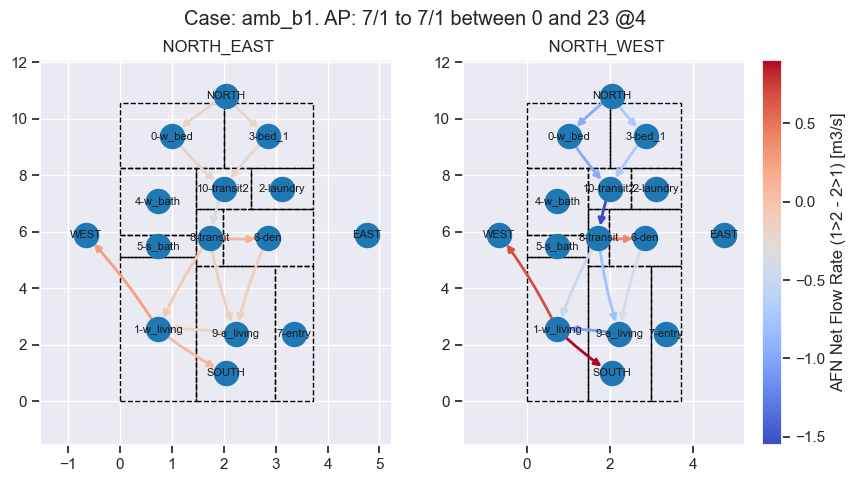

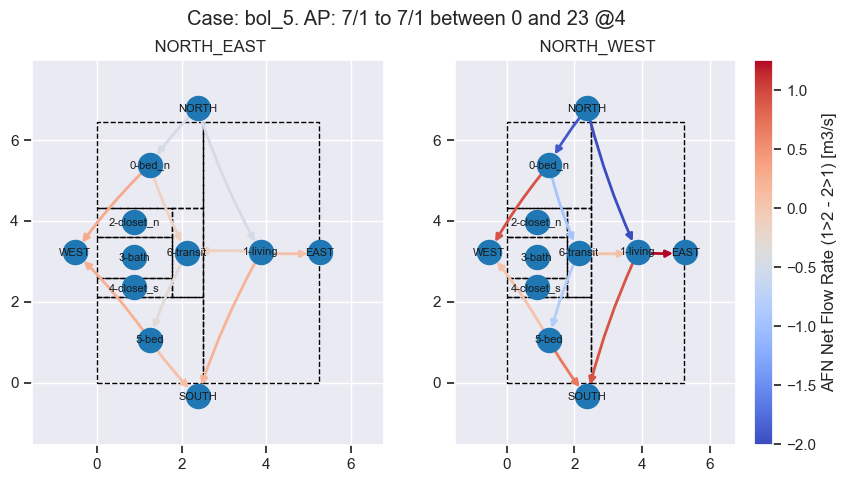

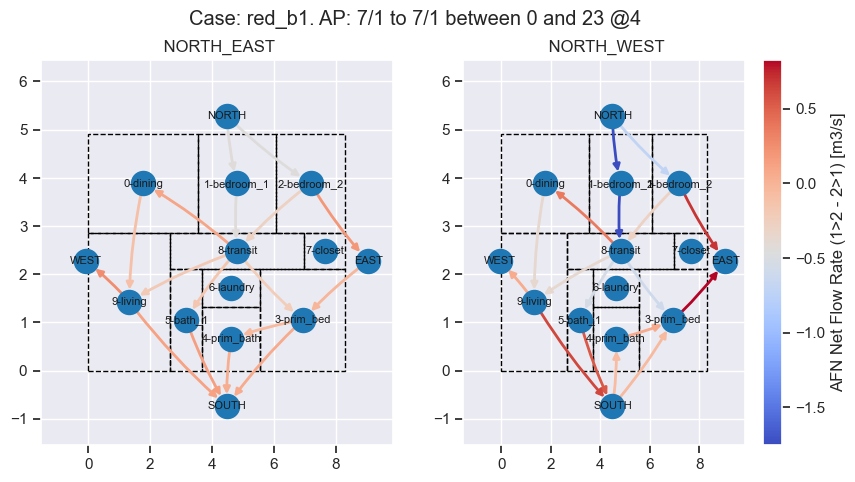

In [278]:
save_figures_for_all_cases("surf_ab_switch", AIRBOUNDARY_FOLDER)

In [176]:
cases = retrieve_cases(AIRBOUNDARY_FOLDER)
case= cases[2]


In [148]:
surfaces = case.idf.getsurfaces()

In [171]:
case.case_name

'red_b1'

In [170]:
afn_zones = case.idf.idfobjects["AIRFLOWNETWORK:MULTIZONE:ZONE"]
afn_zone_names = [i.Zone_Name for i in afn_zones]
afn_zone_names

['Block 03 Storey 0',
 'Block 09 Storey 0',
 'Block 08 Storey 0',
 'Block 05 Storey 0',
 'Block 01 Storey 0',
 'Block 04 Storey 0',
 'Block 02 Storey 0']

In [162]:
case = get_airboundary_with_surf_case()


In [177]:
idf = update_afn_for_airboundary_zones(case.idf)
idf

Block 09 Storey 0 Wall 0001_2 / Block 09 Storey 0 / Block 08 Storey 0 Wall 0003_1 / Block 08 Storey 0
Block 09 Storey 0 Wall 0002_1 / Block 09 Storey 0 / Block 00 Storey 0 Wall 0004_2 / Block 00 Storey 0
Block 00 Storey 0 not in  original AFN. Adding now.. 
Block 08 Storey 0 Wall 0002_1 / Block 08 Storey 0 / Block 00 Storey 0 Wall 0004_1 / Block 00 Storey 0


In [154]:
n = case.idf.idfobjects["CONSTRUCTION:AIRBOUNDARY"][0].Name
remain = n.split(" ")[1:]
res = " ".join(remain)
res

'Block 06 Storey 0 Wall 0001_1'

In [156]:
get_surface_by_name(case.idf, res)


BUILDINGSURFACE:DETAILED,
    Block 06 Storey 0 Wall 0001_1,    !- Name
    wall,                     !- Surface Type
    AirBoundary Block 06 Storey 0 Wall 0001_1,    !- Construction Name
    Block 06 Storey 0,        !- Zone Name
    ,                         !- Space Name
    surface,                  !- Outside Boundary Condition
    Block 01 Storey 0 Wall 0003_2,    !- Outside Boundary Condition Object
    NoSun,                    !- Sun Exposure
    NoWind,                   !- Wind Exposure
    autocalculate,            !- View Factor to Ground
    autocalculate,            !- Number of Vertices
    2.5,                      !- Vertex 1 Xcoordinate
    2.109999999869615,        !- Vertex 1 Ycoordinate
    3.0499999998137355,       !- Vertex 1 Zcoordinate
    2.5,                      !- Vertex 2 Xcoordinate
    2.109999999869615,        !- Vertex 2 Ycoordinate
    0,                        !- Vertex 2 Zcoordinate
    2.5,                      !- Vertex 3 Xcoordinate
    4.3199

In [146]:
case.idf.idfobjects["AIRFLOWNETWORK:MULTIZONE:COMPONENT:SIMPLEOPENING"] # cant use this because

[
AIRFLOWNETWORK:MULTIZONE:COMPONENT:SIMPLEOPENING,
    Block 06 Storey 0 Wall 0001_1 SimpleOpening,    !- Name
    0.001,                    !- Air Mass Flow Coefficient When Opening is Closed
    0.65,                     !- Air Mass Flow Exponent When Opening is Closed
    0.0001,                   !- Minimum Density Difference for TwoWay Flow
    1;                        !- Discharge Coefficient
, 
AIRFLOWNETWORK:MULTIZONE:COMPONENT:SIMPLEOPENING,
    Block 06 Storey 0 Wall 0002_1 Door SimpleOpening,    !- Name
    0.001,                    !- Air Mass Flow Coefficient When Opening is Closed
    0.65,                     !- Air Mass Flow Exponent When Opening is Closed
    0.0001,                   !- Minimum Density Difference for TwoWay Flow
    1;                        !- Discharge Coefficient
, 
AIRFLOWNETWORK:MULTIZONE:COMPONENT:SIMPLEOPENING,
    Block 01 Storey 0 Wall 0004 Window SimpleOpening,    !- Name
    0.001,                    !- Air Mass Flow Coefficient When Open